In [ ]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!nvidia-smi

Tue May  9 07:22:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install wandb


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.0 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=ab1f5e2908f55cacafe4e8fe00039b19428aab19cc57f49670e7ffd8efe51e22
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
!wandb login 3e8c2e01bacb844caa27f15d0c4ae7f63d683a5e

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
!pip install pytorch-lightning


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 15.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torchsummary import summary
import time
import os
import torchvision.transforms.functional as fn
from torch.optim.lr_scheduler import ReduceLROnPlateau as ReduceLROnPlateau
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('USing {} device'.format(device))
import pytorch_lightning as pl
import torchaudio.transforms as T
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import transforms
from torchvision.io import read_image
import  torchvision.transforms as T

USing cuda device


In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self,
                root: str,
                img_dir: str,):
        self.root = root
        self.img_dir = img_dir
        self.img_data = pd.read_csv(img_dir, names=['X_path', 'labels_path'])

        # Use only 50% of the data
        self.img_data = self.img_data.iloc[:len(self.img_data)//2]

        self.transform = T.Compose([
           T.ToPILImage(),
           T.Resize(size = (228, 304)),
           T.RandomApply(transforms=[T.RandomVerticalFlip(p=0.3), T.RandomPerspective(distortion_scale=0.8, p=0.2), T.TrivialAugmentWide()], p=0.8),
           T.ToTensor(),
           T.Normalize((0., 0., 0.), (1., 1. , 1.))
        ])

        self.target_transform = T.Compose([
           T.ToPILImage(),
           T.Resize(size = (55, 74)),
           T.ToTensor(),
           T.Normalize((0.), (1.))
        ])

    def __len__(self):
        return len(self.img_data['X_path'])

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.img_data.iloc[idx, 0])
        image = read_image(img_path)
        label_path = os.path.join(self.root, self.img_data.iloc[idx, 1])
        label = read_image(label_path)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        label = label.float().squeeze()*100
        image = image.float().squeeze()*100
        return image, label


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

data_dir = "/content/gdrive/MyDrive/data/nyu_depth_v2"


img = read_image("/content/gdrive/MyDrive/data/nyu2_train/basement_0001a_out/185.jpg")
img.shape

Mounted at /content/gdrive


torch.Size([3, 480, 640])

In [ ]:
import os

file_path = '/content/gdrive/MyDrive/data/nyu2_train/basement_0001a_out/1.jpg'
#file_path = '/content/gdrive/MyDrive/data'
train_dir = "/content/gdrive/MyDrive/data/nyu2_train.csv"
test_dir = "/content/gdrive/MyDrive/data/nyu2_test.csv"
if os.path.exists(file_path):
    print('File exists')
else:
    print('File does not exist')


File exists


In [ ]:


class Datamodule(pl.LightningDataModule):
    def __init__(self, batch_size: int):
        super().__init__()
        root = "/content/gdrive/MyDrive"
        train_dir = "/content/gdrive/MyDrive/data/depth-estimate/train.csv"
        test_dir = "/content/gdrive/MyDrive/data/depth-estimate/test.csv"
        self.train_set = CustomImageDataset(root, train_dir)
        self.test_set = CustomImageDataset(root, test_dir)
        self.val_set = CustomImageDataset(root, test_dir)
        self.batch_size = batch_size
        
    def train_dataloader(self):
        '''
        DataLoader của hàm train
        '''
        return DataLoader(
            self.train_set,
            batch_size=self.batch_size,
            collate_fn=self.__collate_fn,
            shuffle=True, # shuffle dữ liệu để tạo sự đa dạng,
            drop_last=True
        )

    def val_dataloader(self):
        '''
        DataLoader của hàm validate
        '''
        return DataLoader(
            self.val_set,
            batch_size=self.batch_size,
            collate_fn=self.__collate_fn,
        )

    def test_dataloader(self):
        '''
        DataLoader của hàm test
        '''
        return DataLoader(
            self.test_set,
            batch_size=self.batch_size,
            collate_fn=self.__collate_fn,
        )

    def __collate_fn(self, batch):
        x = torch.stack([i[0] for i in batch])
        y = torch.stack([i[1] for i in batch])
        return x, y

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

data_dir = "/content/gdrive/MyDrive/data/nyu_depth_v2"


img = read_image("/content/gdrive/MyDrive/data/nyu2_train/basement_0001a_out/185.jpg")
img.shape

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


torch.Size([3, 480, 640])

In [ ]:

batch_size = 32
dm = Datamodule(batch_size)

In [ ]:
import os

file_path = '/content/gdrive/MyDrive/data/nyu2_train/basement_0001a_out/1.jpg'

if os.path.exists(file_path):
    print('File exists')
else:
    print('File does not exist')


File exists


In [ ]:
train_loader = dm.train_dataloader()
test_loader = dm.test_dataloader()

Feature batch shape: torch.Size([32, 3, 228, 304])
Labels batch shape: torch.Size([32, 55, 74])


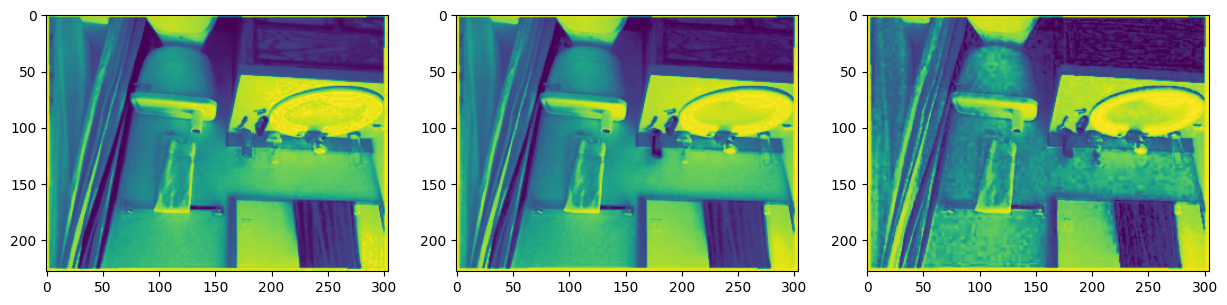

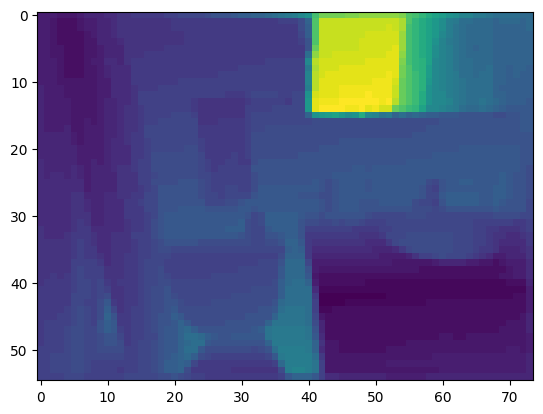

In [ ]:
def vis(img):
    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    axs[0].imshow(img[0])
    axs[1].imshow(img[1])
    axs[2].imshow(img[2])
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0][0]
vis(img)
plt.show()
plt.imshow(label.resize_([55, 74]))

In [ ]:
label.max(), label.min()

(tensor(28.2353), tensor(9.8039))

In [ ]:
class CNN(nn.Module):

    def __init__(self, kernel = 3, 
                 pooling_size = 2, 
                 stride = 2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 50, kernel, padding=1)
        self.conv1_bn = nn.BatchNorm2d(50)
        ##
        self.conv2 = nn.Conv2d(50, 50, kernel, padding=1)
        self.conv2_bn = nn.BatchNorm2d(50)
        ##
        self.conv3 = nn.Conv2d(50, 80, kernel, padding=1)
        self.conv3_bn = nn.BatchNorm2d(80)
        ##
        self.conv4 = nn.Conv2d(80, 80, kernel, padding=1)
        self.conv4_bn = nn.BatchNorm2d(80)
        ##
        self.conv5 = nn.Conv2d(80, 100, kernel, padding=1)
        self.conv5_bn = nn.BatchNorm2d(100)
        ##
        self.conv6 = nn.Conv2d(100, 120, kernel, padding=1)
        self.conv6_bn = nn.BatchNorm2d(120)
        self.conv6_trans = nn.ConvTranspose2d(120, 120, kernel_size=[3, 2], stride=2, padding=1)
        ##
        self.conv7 = nn.Conv2d(120, 1, kernel, padding=1)
        self.conv7_bn = nn.BatchNorm2d(1)





    def forward(self, X):
        out1 = self.conv1_bn(F.relu(self.conv1(X)))        
        out2 = self.conv2_bn(F.relu(self.conv2(out1)))
        out2 = self.conv2_bn(F.relu(self.conv2(out2)))
        out3 = F.max_pool2d(self.conv3_bn(F.relu(self.conv3(out2))), (2, 2))
        out4 = F.max_pool2d(self.conv4_bn(F.relu(self.conv4(out3))), (2, 2))
        out5 = F.max_pool2d(self.conv5_bn(F.relu(self.conv5(out4))), (2, 2))
        out6 = self.conv6_trans(self.conv6_bn(F.relu(self.conv6(out5))))
        out6 = self.conv7_bn(F.relu(self.conv7(out6)))
        output = out6.view(out6.size(0), 55, 74).squeeze()
        return output




'''
class CNN(nn.Module):
    def __init__(self, kernel=3,
                 pooling_size=2,
                 stride=2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel, padding=1)
        self.conv1_bn = nn.BatchNorm2d(32)
        ##
        self.conv2 = nn.Conv2d(32, 32, kernel, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        ##
        self.conv3 = nn.Conv2d(32, 64, kernel, padding=1)
        self.conv3_bn = nn.BatchNorm2d(64)
        ##
        self.conv4 = nn.Conv2d(64, 64, kernel, padding=1)
        self.conv4_bn = nn.BatchNorm2d(64)
        ##
        self.conv5 = nn.Conv2d(64, 1, kernel, padding=1)
        self.conv5_bn = nn.BatchNorm2d(1)

    def forward(self, X):
        out1 = self.conv1_bn(F.relu(self.conv1(X)))
        out2 = F.max_pool2d(self.conv2_bn(F.relu(self.conv2(out1))), (2, 2))
        out3 = self.conv3_bn(F.relu(self.conv3(out2)))
        out4 = F.max_pool2d(self.conv4_bn(F.relu(self.conv4(out3))), (2, 2))
        out5 = self.conv5_bn(F.relu(self.conv5(out4)))
        
        output = F.interpolate(out5, size=(55, 74), mode='bilinear', align_corners=False)
        output = output.view(output.size(0), 55, 74).squeeze()

        return output



class CNN(nn.Module):
    def __init__(self, kernel=3,
                 pooling_size=2,
                 stride=2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel, padding=1)
        self.conv1_bn = nn.BatchNorm2d(32)
        ##
        self.conv2 = nn.Conv2d(32, 32, kernel, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        ##
        self.conv3 = nn.Conv2d(32, 64, kernel, padding=1)
        self.conv3_bn = nn.BatchNorm2d(64)
        ##
        self.conv4 = nn.Conv2d(64, 64, kernel, padding=1)
        self.conv4_bn = nn.BatchNorm2d(64)
        ##
        self.conv5 = nn.Conv2d(64, 1, kernel, padding=1)
        self.conv5_bn = nn.BatchNorm2d(1)

    def forward(self, X):
        out1 = self.conv1_bn(F.relu(self.conv1(X)))
        out2 = F.max_pool2d(self.conv2_bn(F.relu(self.conv2(out1))), (2, 2))
        out3 = self.conv3_bn(F.relu(self.conv3(out2)))
        out4 = F.max_pool2d(self.conv4_bn(F.relu(self.conv4(out3))), (2, 2))
        out5 = self.conv5_bn(F.relu(self.conv5(out4)))
        print(out5.shape)

        output = out5.view(out5.size(0), 57, 76).squeeze()

        return output
'''
'''
class CNN(nn.Module):

    def __init__(self, kernel = 3, 
                 pooling_size = 2, 
                 stride = 2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 50, kernel, padding=1)
        self.conv1_bn = nn.BatchNorm2d(50)
        ##
        self.conv2 = nn.Conv2d(50, 50, kernel, padding=1)
        self.conv2_bn = nn.BatchNorm2d(50)
        ##
        self.conv3 = nn.Conv2d(50, 80, kernel, padding=1)
        self.conv3_bn = nn.BatchNorm2d(80)
        ##
        self.conv4 = nn.Conv2d(80, 80, kernel, padding=1)
        self.conv4_bn = nn.BatchNorm2d(80)
        ##
        self.conv5 = nn.Conv2d(80, 100, kernel, padding=1)
        self.conv5_bn = nn.BatchNorm2d(100)
        ##
        self.conv6 = nn.Conv2d(100, 120, kernel, padding=1)
        self.conv6_bn = nn.BatchNorm2d(120)
        self.conv6_trans = nn.ConvTranspose2d(120, 120, kernel_size=[3, 2], stride=2, padding=1)
        ##
        self.conv7 = nn.Conv2d(120, 1, kernel, padding=1)
        self.conv7_bn = nn.BatchNorm2d(1)





    def forward(self, X):
        out1 = self.conv1_bn(F.relu(self.conv1(X)))        
        out2 = self.conv2_bn(F.relu(self.conv2(out1)))
        out2 = self.conv2_bn(F.relu(self.conv2(out2)))
        out3 = F.max_pool2d(self.conv3_bn(F.relu(self.conv3(out2))), (2, 2))
        out4 = F.max_pool2d(self.conv4_bn(F.relu(self.conv4(out3))), (2, 2))
        out5 = F.max_pool2d(self.conv5_bn(F.relu(self.conv5(out4))), (2, 2))
        out6 = self.conv6_trans(self.conv6_bn(F.relu(self.conv6(out5))))
        out6 = self.conv7_bn(F.relu(self.conv7(out6)))
        output = out6.view(out6.size(0), 55, 74).squeeze()
        return output


'''







'''
  def __init__(self, kernel=3,
                 pooling_size=2,
                 stride=2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel, padding=1)
        self.conv1_bn = nn.BatchNorm2d(32)

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel, padding=1, groups=32),
            nn.Conv2d(32, 50, 1),
        )
        self.conv2_bn = nn.BatchNorm2d(50)

        self.conv3 = nn.Sequential(
            nn.Conv2d(50, 50, kernel, padding=1, groups=50),
            nn.Conv2d(50, 80, 1),
        )
        self.conv3_bn = nn.BatchNorm2d(80)

        self.conv4 = nn.Sequential(
            nn.Conv2d(80, 80, kernel, padding=1, groups=80),
            nn.Conv2d(80, 80, 1),
        )
        self.conv4_bn = nn.BatchNorm2d(80)

        self.conv5 = nn.Sequential(
            nn.Conv2d(80, 80, kernel, padding=1, groups=80),
            nn.Conv2d(80, 100, 1),
        )
        self.conv5_bn = nn.BatchNorm2d(100)

        self.conv6 = nn.Sequential(
            nn.Conv2d(100, 100, kernel, padding=1, groups=100),
            nn.Conv2d(100, 120, 1),
        )
        self.conv6_bn = nn.BatchNorm2d(120)
        self.conv6_trans = nn.ConvTranspose2d(120, 120, kernel_size=[3, 2], stride=2, padding=1)

        self.conv7 = nn.Conv2d(120, 1, kernel, padding=1)
        self.conv7_bn = nn.BatchNorm2d(1)

  def forward(self, x):
        x1 = F.relu(self.conv1_bn(self.conv1(x)))
        x2 = F.relu(self.conv2_bn(self.conv2(x1)))
        x3 = F.relu(self.conv3_bn(self.conv3(x2)))
        x4 = F.relu(self.conv4_bn(self.conv4(x3)))
        x5 = F.relu(self.conv5_bn(self.conv5(x4)))
        x6 = F.relu(self.conv6_bn(self.conv6(x5)) + self.conv6_trans(x5))
        x7 = self.conv7_bn(self.conv7(x6))

        return x7
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 18 * 24, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



'''

#         out6 = torch.flatten(out6, 1) 

'\n  def __init__(self, kernel=3,\n                 pooling_size=2,\n                 stride=2):\n        super(CNN, self).__init__()\n        self.conv1 = nn.Conv2d(3, 32, kernel, padding=1)\n        self.conv1_bn = nn.BatchNorm2d(32)\n\n        self.conv2 = nn.Sequential(\n            nn.Conv2d(32, 32, kernel, padding=1, groups=32),\n            nn.Conv2d(32, 50, 1),\n        )\n        self.conv2_bn = nn.BatchNorm2d(50)\n\n        self.conv3 = nn.Sequential(\n            nn.Conv2d(50, 50, kernel, padding=1, groups=50),\n            nn.Conv2d(50, 80, 1),\n        )\n        self.conv3_bn = nn.BatchNorm2d(80)\n\n        self.conv4 = nn.Sequential(\n            nn.Conv2d(80, 80, kernel, padding=1, groups=80),\n            nn.Conv2d(80, 80, 1),\n        )\n        self.conv4_bn = nn.BatchNorm2d(80)\n\n        self.conv5 = nn.Sequential(\n            nn.Conv2d(80, 80, kernel, padding=1, groups=80),\n            nn.Conv2d(80, 100, 1),\n        )\n        self.conv5_bn = nn.BatchNorm2d(100

In [ ]:
summary(CNN().float().cuda(), (3, 228, 304))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 50, 228, 304]           1,400
       BatchNorm2d-2         [-1, 50, 228, 304]             100
            Conv2d-3         [-1, 50, 228, 304]          22,550
       BatchNorm2d-4         [-1, 50, 228, 304]             100
            Conv2d-5         [-1, 50, 228, 304]          22,550
       BatchNorm2d-6         [-1, 50, 228, 304]             100
            Conv2d-7         [-1, 80, 228, 304]          36,080
       BatchNorm2d-8         [-1, 80, 228, 304]             160
            Conv2d-9         [-1, 80, 114, 152]          57,680
      BatchNorm2d-10         [-1, 80, 114, 152]             160
           Conv2d-11          [-1, 100, 57, 76]          72,100
      BatchNorm2d-12          [-1, 100, 57, 76]             200
           Conv2d-13          [-1, 120, 28, 38]         108,120
      BatchNorm2d-14          [-1, 120,

In [ ]:
class Model(pl.LightningModule):
    def __init__(self, lr : float, total_steps: int):
        super().__init__()
        self.lr = lr
        self.model = CNN()
        self.criterion = nn.MSELoss()
        self.total_steps = total_steps
        self.save_hyperparameters()
        
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, betas=(0.9, 0.98), weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=self.lr, total_steps=self.total_steps, verbose=False,
        )
        scheduler = {
            "scheduler": scheduler,
            "interval": "step",  # or 'epoch'
            "frequency": 1,
        }
        return [optimizer], [scheduler]
    
    def forward(self, x):
      # After getting the output, print the input and target tensor sizes
       # print("Output size:", x.size())
        return self.model(x)

    def training_step(self, batch, batch_idx):
     
       
        img, labels = batch
        outputs = self.model(img)

        # Print the target tensor size
       # print("Target size:", labels.size())

        loss = self.criterion(outputs, labels)

        self.log("train_loss", loss.item())
        
        return loss

    def validation_step(self, batch, batch_idx):
       
        img, labels = batch
        outputs = self.model(img)

        
        # Print the target tensor size
        #print("Target size:", labels.size())
        
        loss = self.criterion(outputs, labels)

        self.log("train_loss", loss.item())

        # lưu lại loss của validate
        self.log("val_loss", loss.item())
#         self.log("val_acc", acc.item())
        return loss
    def test_step(self, batch, batch_idx):
        img, labels = batch
        outputs = self.model(img)
        loss = self.criterion(outputs, labels)

        self.log("train_loss", loss.item())

        # lưu lại loss của test
        self.log("test_loss", loss.item())
#         self.log("test_acc", acc.item())
        return loss

In [ ]:
#max_epochs = 15
max_epochs = 1


lr = 0.001
total_steps = len(dm.train_dataloader()) * max_epochs
model = Model(lr=lr, total_steps=total_steps)

In [ ]:
!pip install wandb


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install --upgrade pytorch-lightning


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!wandb login --relogin 

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:

wandb_logger = pl.loggers.WandbLogger(
    project="depth_estimation", name='model_CNN_origin_with_mix_data', log_model="all"
)
lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval="step")

trainer = pl.Trainer(
    logger=wandb_logger,
    callbacks=[lr_monitor],
    max_epochs=max_epochs,
    accelerator="auto",
    log_every_n_steps=1,
    gradient_clip_val=2
)

wandb: Currently logged in as: howardhalikelynn (cool301). Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, datamodule=dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params
--------------------------------------
0 | model     | CNN     | 386 K 
1 | criterion | MSELoss | 0     
--------------------------------------
386 K     Trainable params
0         Non-trainable params
386 K     Total params
1.546     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
# model= Model(lr = lr, total_steps=total_steps)
# PATH = "../input/depth-estimate/CNN_epoch14.ckpt"
# checkpoint = torch.load(PATH)
# model.load_from_checkpoint(PATH)

In [ ]:
train_loader = dm.train_dataloader()
test_loader = dm.test_dataloader()

In [ ]:
test_features, test_labels = dm.test_set[365]
test_features, test_labels = test_features, test_labels

In [ ]:
test_features.shape,test_labels.shape

(torch.Size([3, 228, 304]), torch.Size([55, 74]))

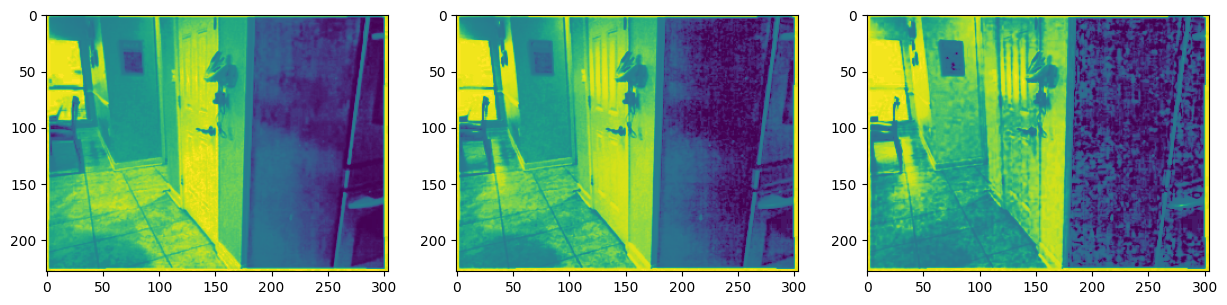

In [ ]:
vis(test_features)

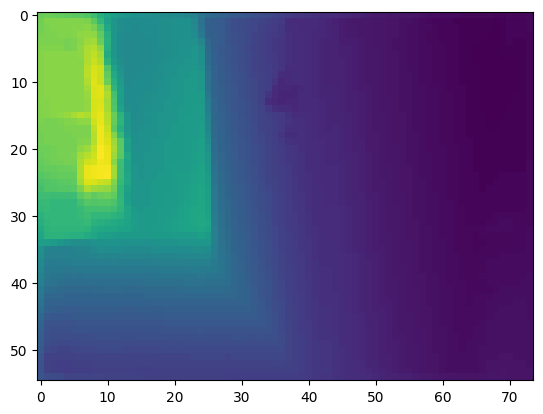

In [ ]:
plt.imshow(test_labels.cpu().view(55, 74))

In [ ]:
print(test_labels.shape, test_features.shape)

torch.Size([55, 74]) torch.Size([3, 228, 304])


In [ ]:
predict = model(test_features.cpu().unsqueeze(0))
predict.shape

torch.Size([55, 74])

In [ ]:
predict.min()

tensor(-1.9057, grad_fn=<MinBackward1>)

In [ ]:
loss = nn.MSELoss()
loss(predict.cuda(), test_labels.cuda())

tensor(678.8723, device='cuda:0', grad_fn=<MseLossBackward0>)

In [ ]:
predict.max()

tensor(5.4674, grad_fn=<MaxBackward1>)

<ipython-input-37-3728b30eb385>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(torch.tensor(predict.squeeze().cpu()).view(55, 74))


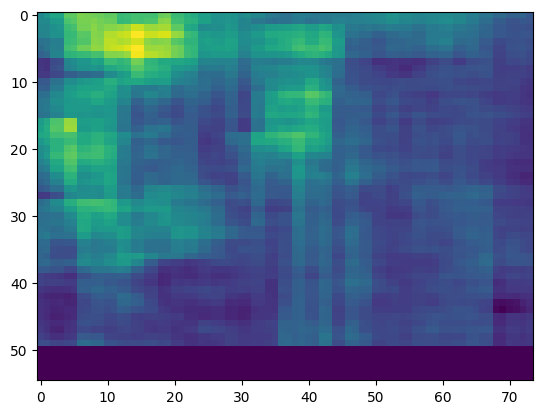

In [ ]:
plt.imshow(torch.tensor(predict.squeeze().cpu()).view(55, 74))

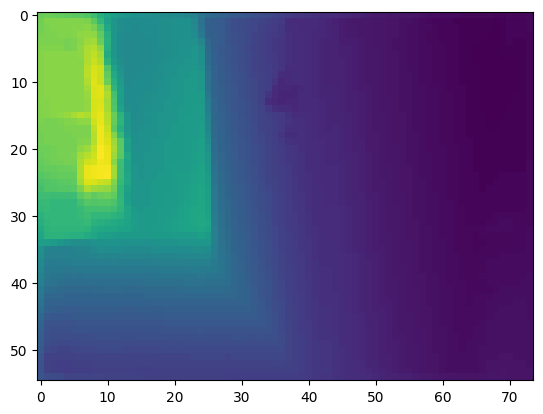

In [ ]:
plt.imshow(test_labels.cpu())

In [ ]:
def predict_multi(model, X):
    lst = []
    for img in X:
        y = model(img.unsqueeze(0))
        lst.append(y)
#         print(y.unsqueeze(0).shape)
    return lst

In [ ]:
def vis_subplot(Yhat, target, inf = "target"):
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))
    k = 0
    loss = nn.MSELoss()
    for i in range(3):
        for j in range(3):
            score = loss(Yhat[k], target[k])
            axs[i, j].imshow(torch.tensor(Yhat[k].squeeze().cpu()).view(55, 74))
            k+=1
            if(inf == "predict"):
                axs[i, j].set_title("Image {}, loss {}".format(k+1, int(score)))
            else:
                axs[i, j].set_title("Image {}".format(k+1))
    

In [ ]:
img_inputs = []
imgs_labels = []
list_predict = []
for i in range(32):
    sample_idx = torch.randint(2000, size=(1,)).item()
    img, img_label = dm.train_set[sample_idx]
    img_inputs.append(img)
    imgs_labels.append(img_label)
    list_predict.append(model(img.unsqueeze(0)))

<ipython-input-40-d758c02dc4b3>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  axs[i, j].imshow(torch.tensor(Yhat[k].squeeze().cpu()).view(55, 74))


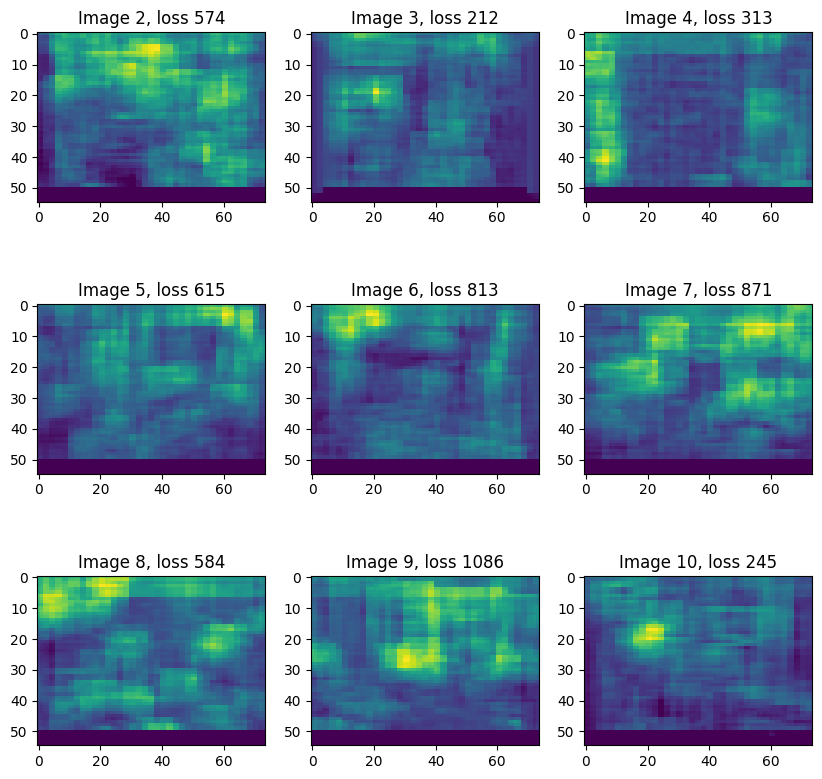

In [ ]:
vis_subplot(list_predict, imgs_labels, "predict")

<ipython-input-40-d758c02dc4b3>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  axs[i, j].imshow(torch.tensor(Yhat[k].squeeze().cpu()).view(55, 74))


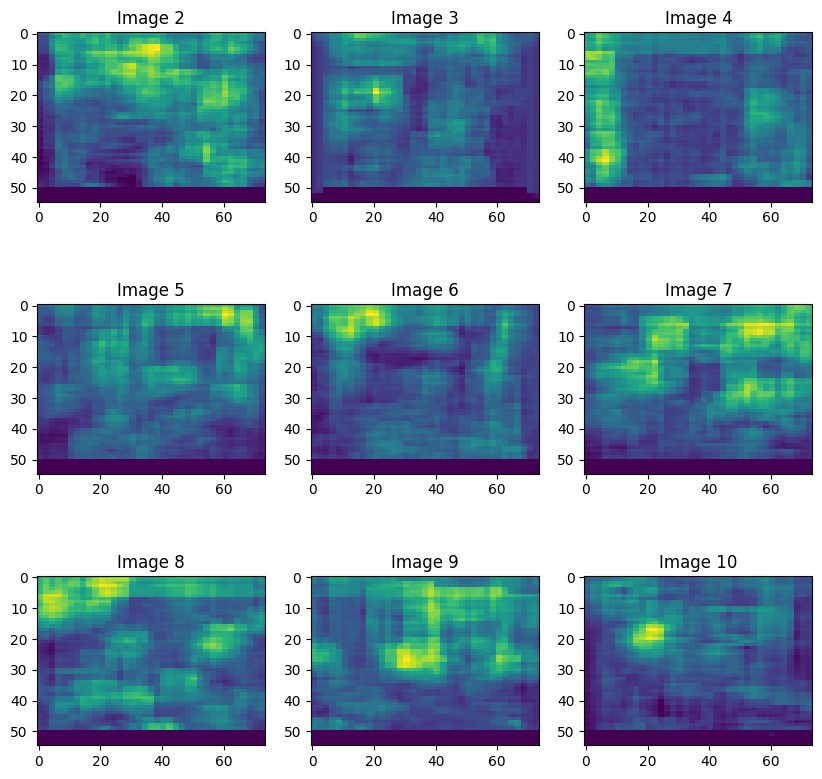

In [ ]:
vis_subplot(list_predict, imgs_labels)

<ipython-input-40-d758c02dc4b3>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  axs[i, j].imshow(torch.tensor(Yhat[k].squeeze().cpu()).view(55, 74))


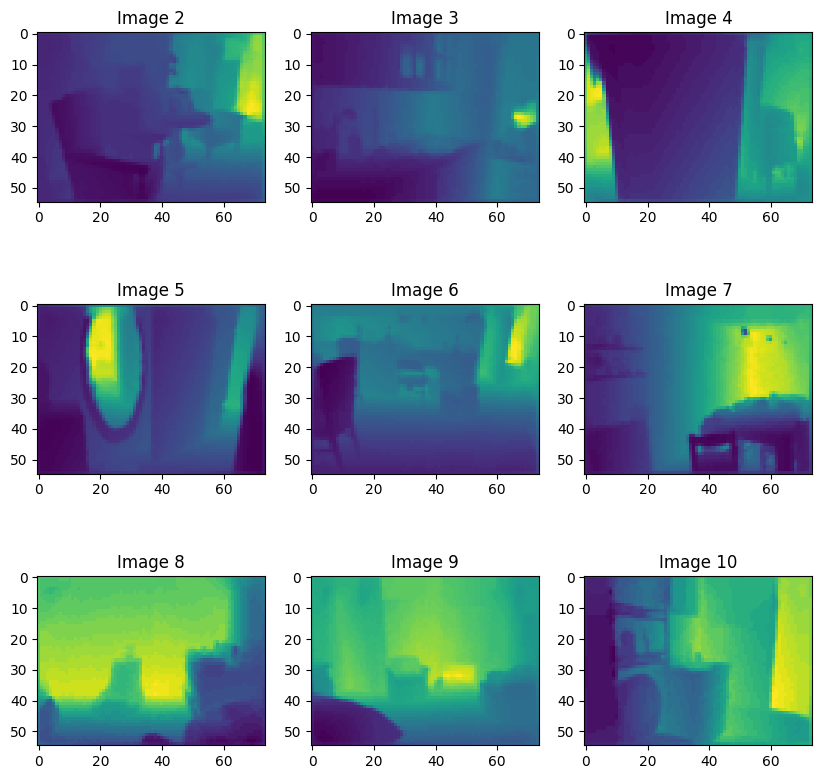

In [ ]:
vis_subplot(imgs_labels, imgs_labels)